# Age prediction by photo

## Task

A chain supermarket is implementing a computer vision system to process customer photos. Photofixing in the checkout area will help determine the age of customers in order to:
- Analyze purchases and suggest products that may be of interest to customers of this age group;
- Monitor the integrity of cashiers when selling alcohol.

We need to build a model that determines the approximate age of a person from a photograph.
Quality metric threshold: MAE < 8.

## Data

The training dataset was taken from the website [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/). 

The photos are in the folder `/datasets/faces/`. 

There is one folder with all the images `/final_files` and a CSV file  `labels.csv` with two columns: `file_name` and `real_age`. 

We are going to retrieve the data from a folder using [`ImageDataGenerator`](https://keras.io/preprocessing/image/) — [`flow_from_dataframe(dataframe, directory, ...)`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

It is [known](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf) that MAE = 5.4 can be achieved on this data.

Citation:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-09-23 15:10:08.093052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-23 15:10:08.093076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Exploratory data analysis

Let's have a look at the dataset and:
- Find out the sample size.
- Plot the distribution of age in the sample.
- Print 10-15 photos on the screen and see how the dataset is organized.

We also shall estimate how the data specifics may affect model training.

### Sample size

In [2]:
try:
    labels_train = pd.read_csv('appa-real/gt_avg_train.csv')
    labels_valid = pd.read_csv('appa-real/gt_avg_valid.csv')
    labels_test = pd.read_csv('appa-real/gt_avg_test.csv')
    
    labels = pd.concat([labels_train, labels_valid, labels_test])[['file_name', 'real_age']]
    
    datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
            dataframe=labels,
            directory='appa-real/all',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32, 
            class_mode='raw',
            seed=12345)
    
except:
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345)

Found 2395 validated image filenames.


/home/leonid/anaconda3/envs/practicum/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 5196 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
1973,007608.jpg,14
1974,007609.jpg,37
1975,007610.jpg,28
1976,007611.jpg,20


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7591 entries, 0 to 1977
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 177.9+ KB


There are no gaps in the numbers themselves.

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


The mean is higher than the median, indicating that the dataset is skewed positively.
No abnormal values are observed.

### Data distribution

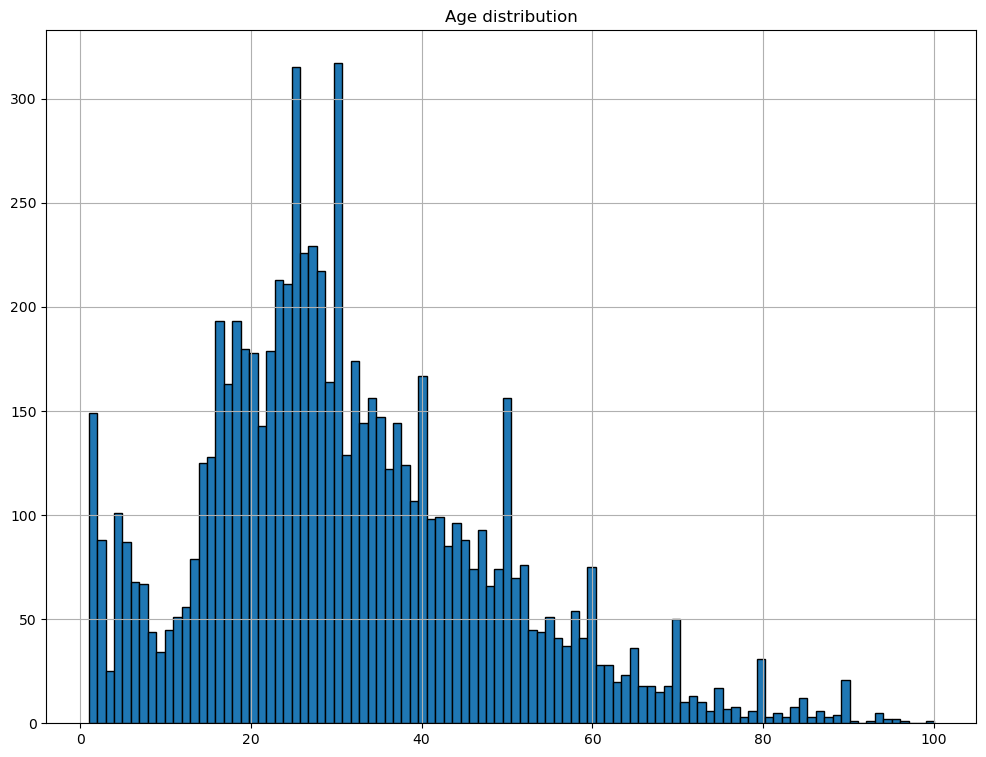

In [6]:
labels['real_age'].hist(bins=100, figsize=(12, 9), edgecolor='black')
plt.title("Age distribution")
plt.show()

In [7]:
labels['real_age'].value_counts().head()

30    317
25    315
27    229
26    226
28    217
Name: real_age, dtype: int64

There are significantly more photos with young people than photos with older or younger people.

Quite a lot of photos with babies. But there are not so much pictures of elderly people.
This is unfortunate, because pensioners are more likely to be seen at the cash register than infants.

If we were to distinguish age groups, we would need to account for class imbalance. This is unlikely to be the case in the regression task, although we could add more augmentations for pictures with elderly people.

Let's try to estimate the amount of data by age group.

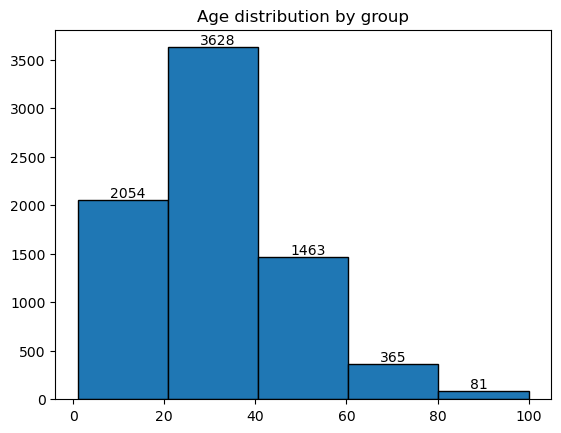

In [8]:
fig = plt.hist(labels['real_age'], bins=5, edgecolor='black')
for i in range(5):
    plt.text(fig[1][i] + 7, fig[0][i] + 30, str(int(fig[0][i])))
plt.title("Age distribution by group")
plt.show()

For older age groups, there is clearly insufficient data amount.

### Examples

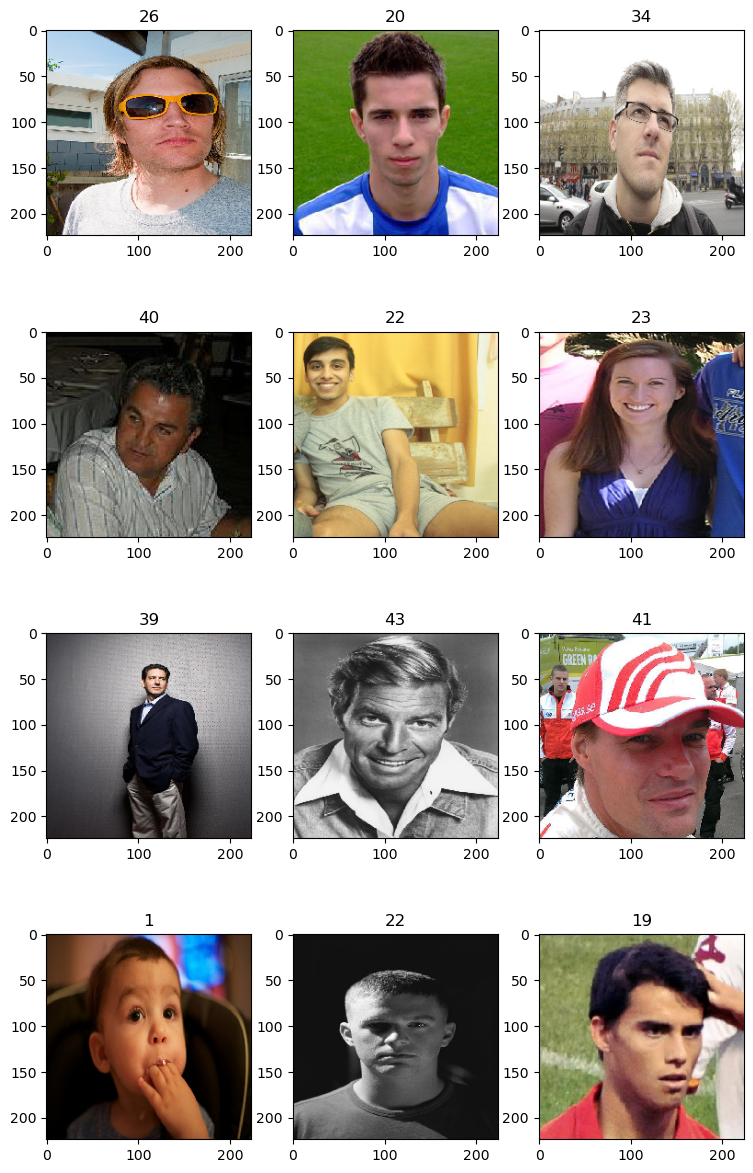

In [9]:
fig = plt.figure(figsize=(9, 15))
columns = 3
rows = 4
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_gen_flow[0][0][i - 1])
    plt.title(train_gen_flow[0][1][i - 1])
plt.show()

### Conclusion

1. Training will be conducted on 7591 photographs. Of these, 25% will be taken for the validation sample.
2. Most of the photos are color, with 3 channels. They have all been compressed to 224 by 224 pixels.
3. The distribution is not normal, although it resembles it (centered around age 25). There are a large number of photographs of infants. And even more photos of people 25 and 30 years old.
4. On the contrary, there are few photos of older people. This age imbalance may affect the training procedure. If evaluated by age groups, the data are sufficient.
5. The labelling of the photos is correct.

## Model training

Recommendations for training are as follows:
- The loss function does not necessarily have to be MAE. Often neural networks with MSE loss function are trained faster.
- If the quality on the validation sample improves, but the model overtrains more and more, it is not necessary to change the model. Usually neural networks with a large number of layers overtrain strongly.

In [10]:
# imports for GPU simulator
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
'''

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1. / 255, 
        horizontal_flip=True, 
        height_shift_range=0.2, 
        width_shift_range=0.2)
    
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32, 
        subset='training', 
        class_mode='raw',
        seed=12345)
    
    return train_data


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1/255.)
    
    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32, 
        subset='validation', 
        class_mode='raw',
        seed=12345)

    return test_data


def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(
        input_shape=input_shape, 
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
        include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, 
                batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

In the GPU simulator, the following result was obtained on these functions:

## Results

The testing threshold of MAE < 8 is passed (even by a small margin).

On the other hand, we see that the model is overtrained: validation on the training sample gives `MAE= 5.2295`, while in testing the model shows `MAE= 6.3274`.
This corresponds to about the third epoch of training (out of five conducted).

## Conclusions

1. The data is a set of 7591 color photos (and a small number of black and white photos).
2. The photos are of different sizes, but for training they were compressed to the same size of 224 by 224 pixels.
3. There is a significant age imbalance in the data: there are noticeably more young people (18 to 30) than other age groups. There are also many pictures of infants. If we group the data by age groups, there are enough photos for training.
4. For the training, was used a convolutional network ResNet50, which used pre-selected weights as input values.
5. Augmentations were used in training: reflections of photos horizontally and shifts of 20% of pixels vertically and horizontally.
6. The model was trained on 5 epochs, that is, it adjusted the coefficients in the fully connected layer to the transformed photographs (loss function - MSE) 5 times. This resulted in overtraining. Thus, the MAE was `11.13` at the first epoch and `5.23` at the fifth epoch. The error on the test sample was `6.33`, which corresponds to about the third epoch of training.
7. Optimization was performed by the Adam algorithm with a learning rate equal to 0.0001. During each epoch it was carried out in 178 steps, at 60 of which there was validation.
8. The trained model can determine the age of customers with an average error of at least 6 years (in practice it can be more). In this regard, this model can be used to analyze purchases and proposals of goods.
9. However, it cannot be used to control the integrity of cashiers when selling alcohol: it is not accurate enough.